## Capstone 3: Store Item Demand Forecasting 

**1. Data Loading and Wrangling**

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
#load the original downloaded excel file from Kaggle

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print("First 5 samples of training data \n\n", df_train.head())
print("\n\nFirst 5 samples of test data \n\n", df_test.head())

First 5 samples of training data 

          date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10


First 5 samples of test data 

    id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1


The raw data is loaded. Training data has four columns: date, store, item, sales. The test data has 4 columns: id, date, store, item. The sales value from test data has to be forecasted. 

Next we will analyze the data which include:
- Check shape of the file
- Check datatype
- Generate desciptive statistics for each column
- Check for null values


In [3]:
print("The shape of the training data is: \n", df_train.shape,"\n")
print("The shape of the test data is: \n", df_test.shape)

print("\nThe datatypes for the columns in the training data are:")
print(df_train.info())
print("\nThe datatypes for the columns in the test data are:")
print(df_test.info())

The shape of the training data is: 
 (913000, 4) 

The shape of the test data is: 
 (45000, 4)

The datatypes for the columns in the training data are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

The datatypes for the columns in the test data are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
None


Out of the four columns 'store', 'item' and 'sales' have integer values and 'date' seems to be an object. For time series analysis this column will be converted to a pandas date-time object. 

For the test data, there is no sales as it is meant to be forecasted. The data follows the same format as the trainig data. 

In [4]:
print("Basic statistics for the columns from the training data: \n")
print(df_train.describe().round(2))

print("\nBasic statistics for the columns from the test data: \n")
print(df_test.describe().round(2))

Basic statistics for the columns from the training data: 

           store       item      sales
count  913000.00  913000.00  913000.00
mean        5.50      25.50      52.25
std         2.87      14.43      28.80
min         1.00       1.00       0.00
25%         3.00      13.00      30.00
50%         5.50      25.50      47.00
75%         8.00      38.00      70.00
max        10.00      50.00     231.00

Basic statistics for the columns from the test data: 

             id     store      item
count  45000.00  45000.00  45000.00
mean   22499.50      5.50     25.50
std    12990.53      2.87     14.43
min        0.00      1.00      1.00
25%    11249.75      3.00     13.00
50%    22499.50      5.50     25.50
75%    33749.25      8.00     38.00
max    44999.00     10.00     50.00


Let us explore more for the training data to find out what are the unique store_id values and unique item_id values. 

In [5]:
print("Below is a list of unique store ids in the training data and their representation: \n") 
print(df_train['store'].value_counts())

Below is a list of unique store ids in the training data and their representation: 

1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: store, dtype: int64


In [6]:
print("Below is a list of unique items in the training data and their representation: \n") 
print(df_train['item'].value_counts().sort_index())

Below is a list of unique items in the training data and their representation: 

1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: item, dtype: int64


There are a total of 10 stores and each store sells 50 items. The data is very uniform in representation i.e. the number of datapoints for each subset of store-item combination is exactly the same. Very likely this is a synthetic dataset. 

In [7]:
print("Below is a list of null values in the trianing dataset:")
print(df_train.isnull().sum())

print("\nBelow is a list of null values in the test dataset:")
print(df_test.isnull().sum())

Below is a list of null values in the trianing dataset:
date     0
store    0
item     0
sales    0
dtype: int64

Below is a list of null values in the test dataset:
id       0
date     0
store    0
item     0
dtype: int64


There are no null values in the training and the test data. The data is clean and ready for analysis. 

**2) EDA**

- Convert time variable to pandas datetime object
- Generate other columns for date such as day of the week, month, year etc. 
- Check total time range: start date, end date, total number of days
- Check for missing days 
- Generate summary stats for each store
- Generate summary stats for each item
- Plot histogram of daily sales for each store and all stores combined
- Plot box plots for each day of the week for each store and all stores combined
- Time plot of daily sales for each store
- Time plot of daily sales for each store with a moving average window
- Time plot of weekly sales for each store
- Time plot of monthly sales for each store
- Correlation plot for daily sales from different stores
- Check for any degenracies in the data

In [8]:
# Convert time variable to pandas datetime object
# Generate other columns for date such as day of the week, month, year etc.

df_train['date'] = pd.to_datetime(df_train['date'], format="%Y-%m-%d")

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day_of_year'] = df_train['date'].dt.dayofyear
df_train['week'] = df_train['date'].dt.weekofyear
df_train['day_of_week'] = df_train['date'].dt.dayofweek + 1

df_train.head(40)

,date,store,item,sales,year,month,day_of_year,week,day_of_week
0,2013-01-01,1,1,13,2013,1,1,1,2
1,2013-01-02,1,1,11,2013,1,2,1,3
2,2013-01-03,1,1,14,2013,1,3,1,4
3,2013-01-04,1,1,13,2013,1,4,1,5
4,2013-01-05,1,1,10,2013,1,5,1,6
5,2013-01-06,1,1,12,2013,1,6,1,7
6,2013-01-07,1,1,10,2013,1,7,2,1
7,2013-01-08,1,1,9,2013,1,8,2,2
8,2013-01-09,1,1,12,2013,1,9,2,3
9,2013-01-10,1,1,9,2013,1,10,2,4


In [9]:
# Check total time range: start date, end date, total number of days
# Check for missing days

print('The start date for the dataset is:\n', df_train['date'].min().date())
print('The end date for the dataset is:\n', df_train['date'].max().date())

tot_days = (df_train['date'].max().date() - df_train['date'].min().date()).days + 1
print('The total number of days for the dataset is:\n', tot_days)

print('The total number of entries for the dataset is:\n', tot_days*10*50)

The start date for the dataset is:
 2013-01-01
The end date for the dataset is:
 2017-12-31
The total number of days for the dataset is:
 1826
The total number of entries for the dataset is:
 913000


There are no missing days in the dataset. There is an entry for each store, item and day in this dataset. 

In [10]:
# Generate summary stats for each store
# Generate summary stats for each item

store_sales = df_train.groupby('store', as_index=True)['sales'].agg(['count', 'sum', 'mean', 'median', 'std', 'min', 'max']).reset_index()
item_sales = df_train.groupby('item', as_index=True)['sales'].agg(['count', 'sum', 'mean', 'median', 'std', 'min', 'max']).reset_index()

print("Summary statistics for sales at each store")
print(store_sales)
print("\nSummary statistics for sales for each item")
print(item_sales)

Summary statistics for sales at each store
   store  count      sum       mean  median        std  min  max
0      1  91300  4315603  47.268379    44.0  24.006252    1  155
1      2  91300  6120128  67.033165    62.0  33.595810    3  231
2      3  91300  5435144  59.530602    55.0  29.974102    3  196
3      4  91300  5012639  54.902946    51.0  27.733097    4  186
4      5  91300  3631016  39.770164    37.0  20.365757    2  130
5      6  91300  3627670  39.733516    37.0  20.310451    0  134
6      7  91300  3320009  36.363735    34.0  18.684825    1  122
7      8  91300  5856169  64.142048    60.0  32.231751    4  204
8      9  91300  5025976  55.049025    51.0  27.832186    4  195
9     10  91300  5360158  58.709288    54.0  29.554994    3  187

Summary statistics for sales for each item
    item  count      sum       mean  median        std  min  max
0      1  18260   401384  21.981599    21.0   8.468922    1   59
1      2  18260  1069564  58.574151    56.0  20.093015    9  150
2  

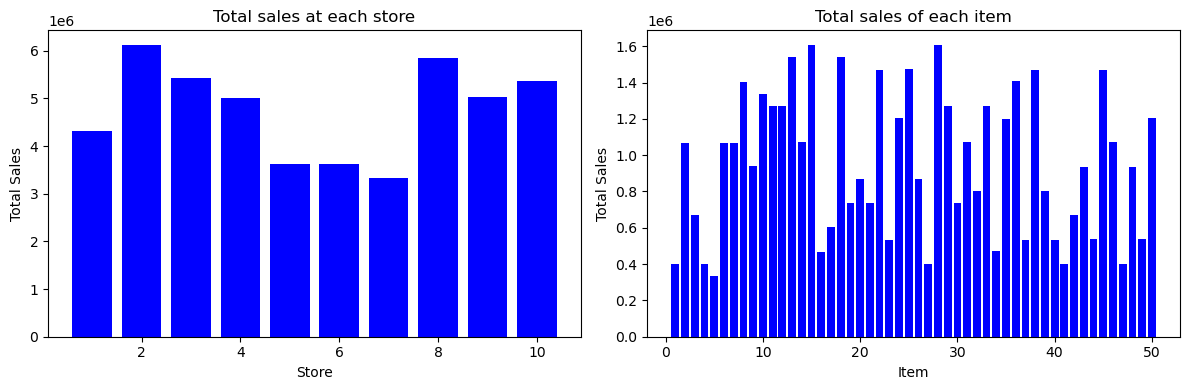

In [11]:
# Plot the total sales for each store and item 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot in the first subplot (index 0)
ax[0].bar(store_sales['store'], store_sales['sum'], color='b')
ax[0].set_title("Total sales at each store")
ax[0].set_xlabel('Store')
ax[0].set_ylabel('Total Sales')

# Plot in the second subplot (index 1)
ax[1].bar(item_sales['item'], item_sales['sum'], color='b')
ax[1].set_title("Total sales of each item")
ax[1].set_xlabel('Item')
ax[1].set_ylabel('Total Sales')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [12]:
# Calculate daily sales for each store and for all stores combined

daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
daily_store_sales = df_train.groupby(['date', 'store'])['sales'].sum().reset_index()

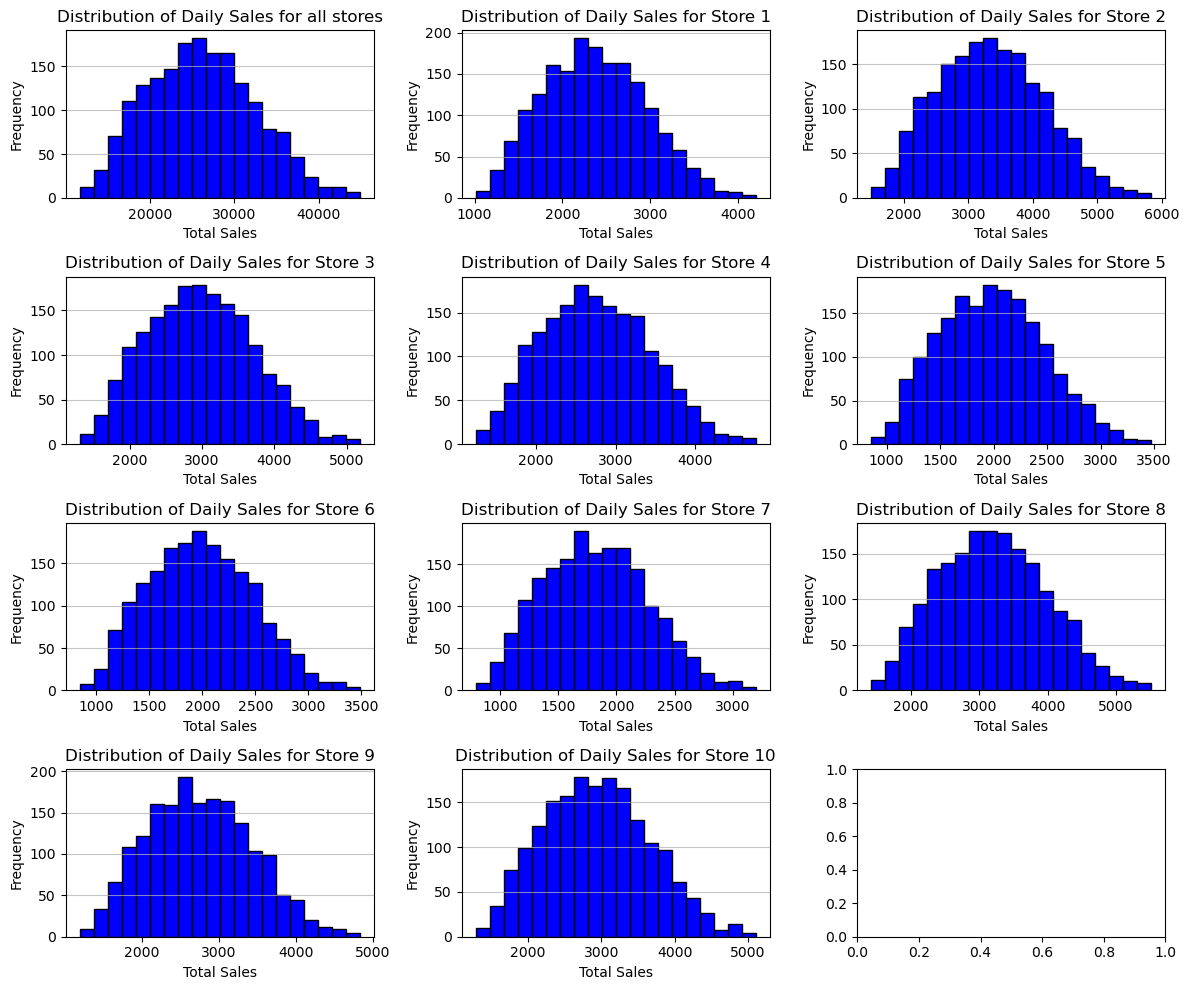

In [13]:
# Plot histograms of daily sales all for each store and all stores combined 

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
custom_bins = 20

ax[0, 0].hist(daily_sales['sales'], bins=custom_bins, color='b', edgecolor='black')
ax[0, 0].set_title(f'Distribution of Daily Sales for all stores')
ax[0, 0].set_xlabel('Total Sales')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].grid(axis='y', alpha=0.75)

for store_number in range(1, 11):  # Range from 1 to 10 (inclusive)
    i, j = divmod(store_number, 3)  # Calculate the row and column indices based on store_number
    
    # Plot starting from the first row and second column
    store_data = daily_store_sales[daily_store_sales['store'] == store_number]['sales']

    ax[i, j].hist(store_data, bins=custom_bins, color='b', edgecolor='black')
    ax[i, j].set_title(f'Distribution of Daily Sales for Store {store_number}')
    ax[i, j].set_xlabel('Total Sales')
    ax[i, j].set_ylabel('Frequency')
    ax[i, j].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

The distribution of the sales for each store are very similar. 

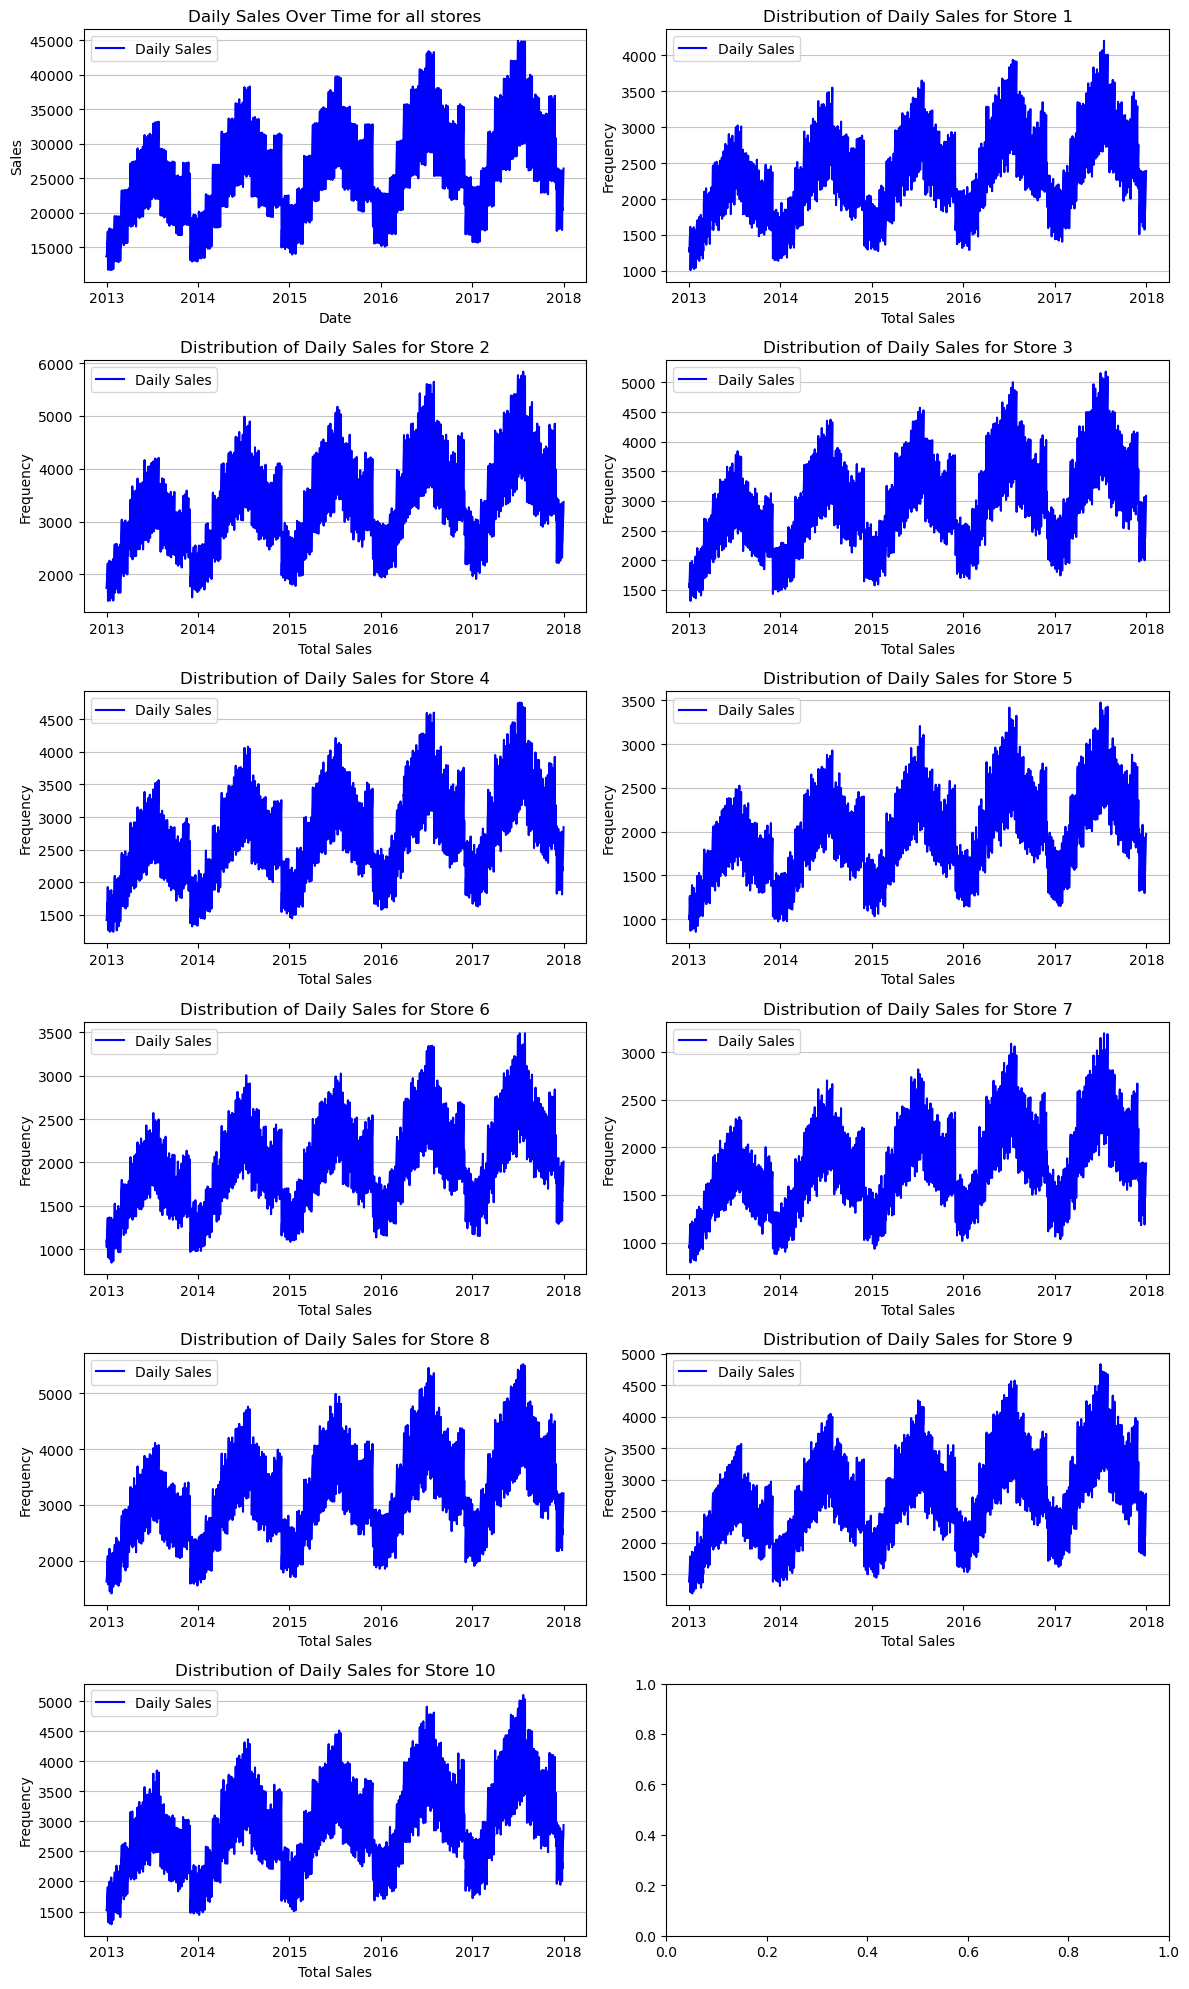

In [14]:
# Time plots of daily sales for each store and all stores combined

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 20))

ax[0,0].plot(daily_sales['date'], daily_sales['sales'], label='Daily Sales', color='b', linestyle='-')
ax[0,0].set_title('Daily Sales Over Time for all stores')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Sales')
ax[0,0].legend(loc='upper left')
ax[0,0].grid(axis='y', alpha=0.75)

for store_number in range(1, 11):  # Range from 1 to 10 (inclusive)
    i, j = divmod(store_number, 2)  # Calculate the row and column indices based on store_number
    
    # Plot starting from the second row and first column
    store_data = daily_store_sales[daily_store_sales['store'] == store_number]['sales']
    store_date = daily_store_sales[daily_store_sales['store'] == store_number]['date']

    ax[i, j].plot(store_date, store_data, label='Daily Sales', color='b', linestyle='-')
    ax[i, j].set_title(f'Distribution of Daily Sales for Store {store_number}')
    ax[i, j].set_xlabel('Total Sales')
    ax[i, j].set_ylabel('Frequency')
    ax[i, j].legend(loc='upper left')
    ax[i, j].grid(axis='y', alpha=0.75)
    
plt.tight_layout()
plt.show()

The time series plots ofr each store are very alike with obvious trend and seasonality patterns which will be explored later. 

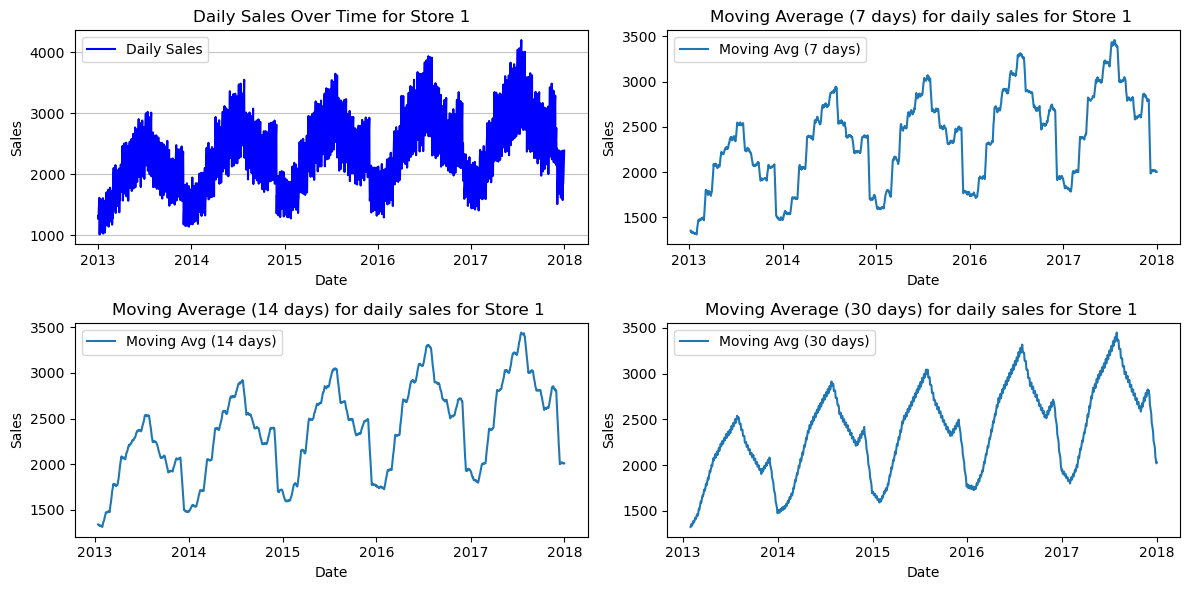

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

daily_store1_sales = daily_store_sales[daily_store_sales['store'] == 1]
ax[0,0].plot(daily_store1_sales['date'], daily_store1_sales['sales'], label='Daily Sales', color='b', linestyle='-')
ax[0,0].set_title('Daily Sales Over Time for Store 1')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Sales')
ax[0,0].legend(loc='upper left')
ax[0,0].grid(axis='y', alpha=0.75)

# Generate moving average plots for different window sizes
window_sizes = [7, 14, 30]  # Define the window sizes for moving averages
iii = 1

for window_size in window_sizes:
    # Calculate the moving average using the specified window size
    moving_avg = daily_store1_sales['sales'].rolling(window=window_size).mean()
    
    i, j = divmod(iii, 2)
    iii = iii + 1

    # Plot the moving average on separate subplots
    ax[i,j].plot(daily_store1_sales['date'], moving_avg, label=f'Moving Avg ({window_size} days)')  
    ax[i,j].set_xlabel('Date')
    ax[i,j].set_ylabel('Sales')
    ax[i,j].set_title(f'Moving Average ({window_size} days) for daily sales for Store 1 ')
    ax[i,j].legend(loc='upper left')

plt.tight_layout()
plt.show()   

The moving verage plots show very strong yearly seasonal effects. There could be some monthly seasonality as well. 

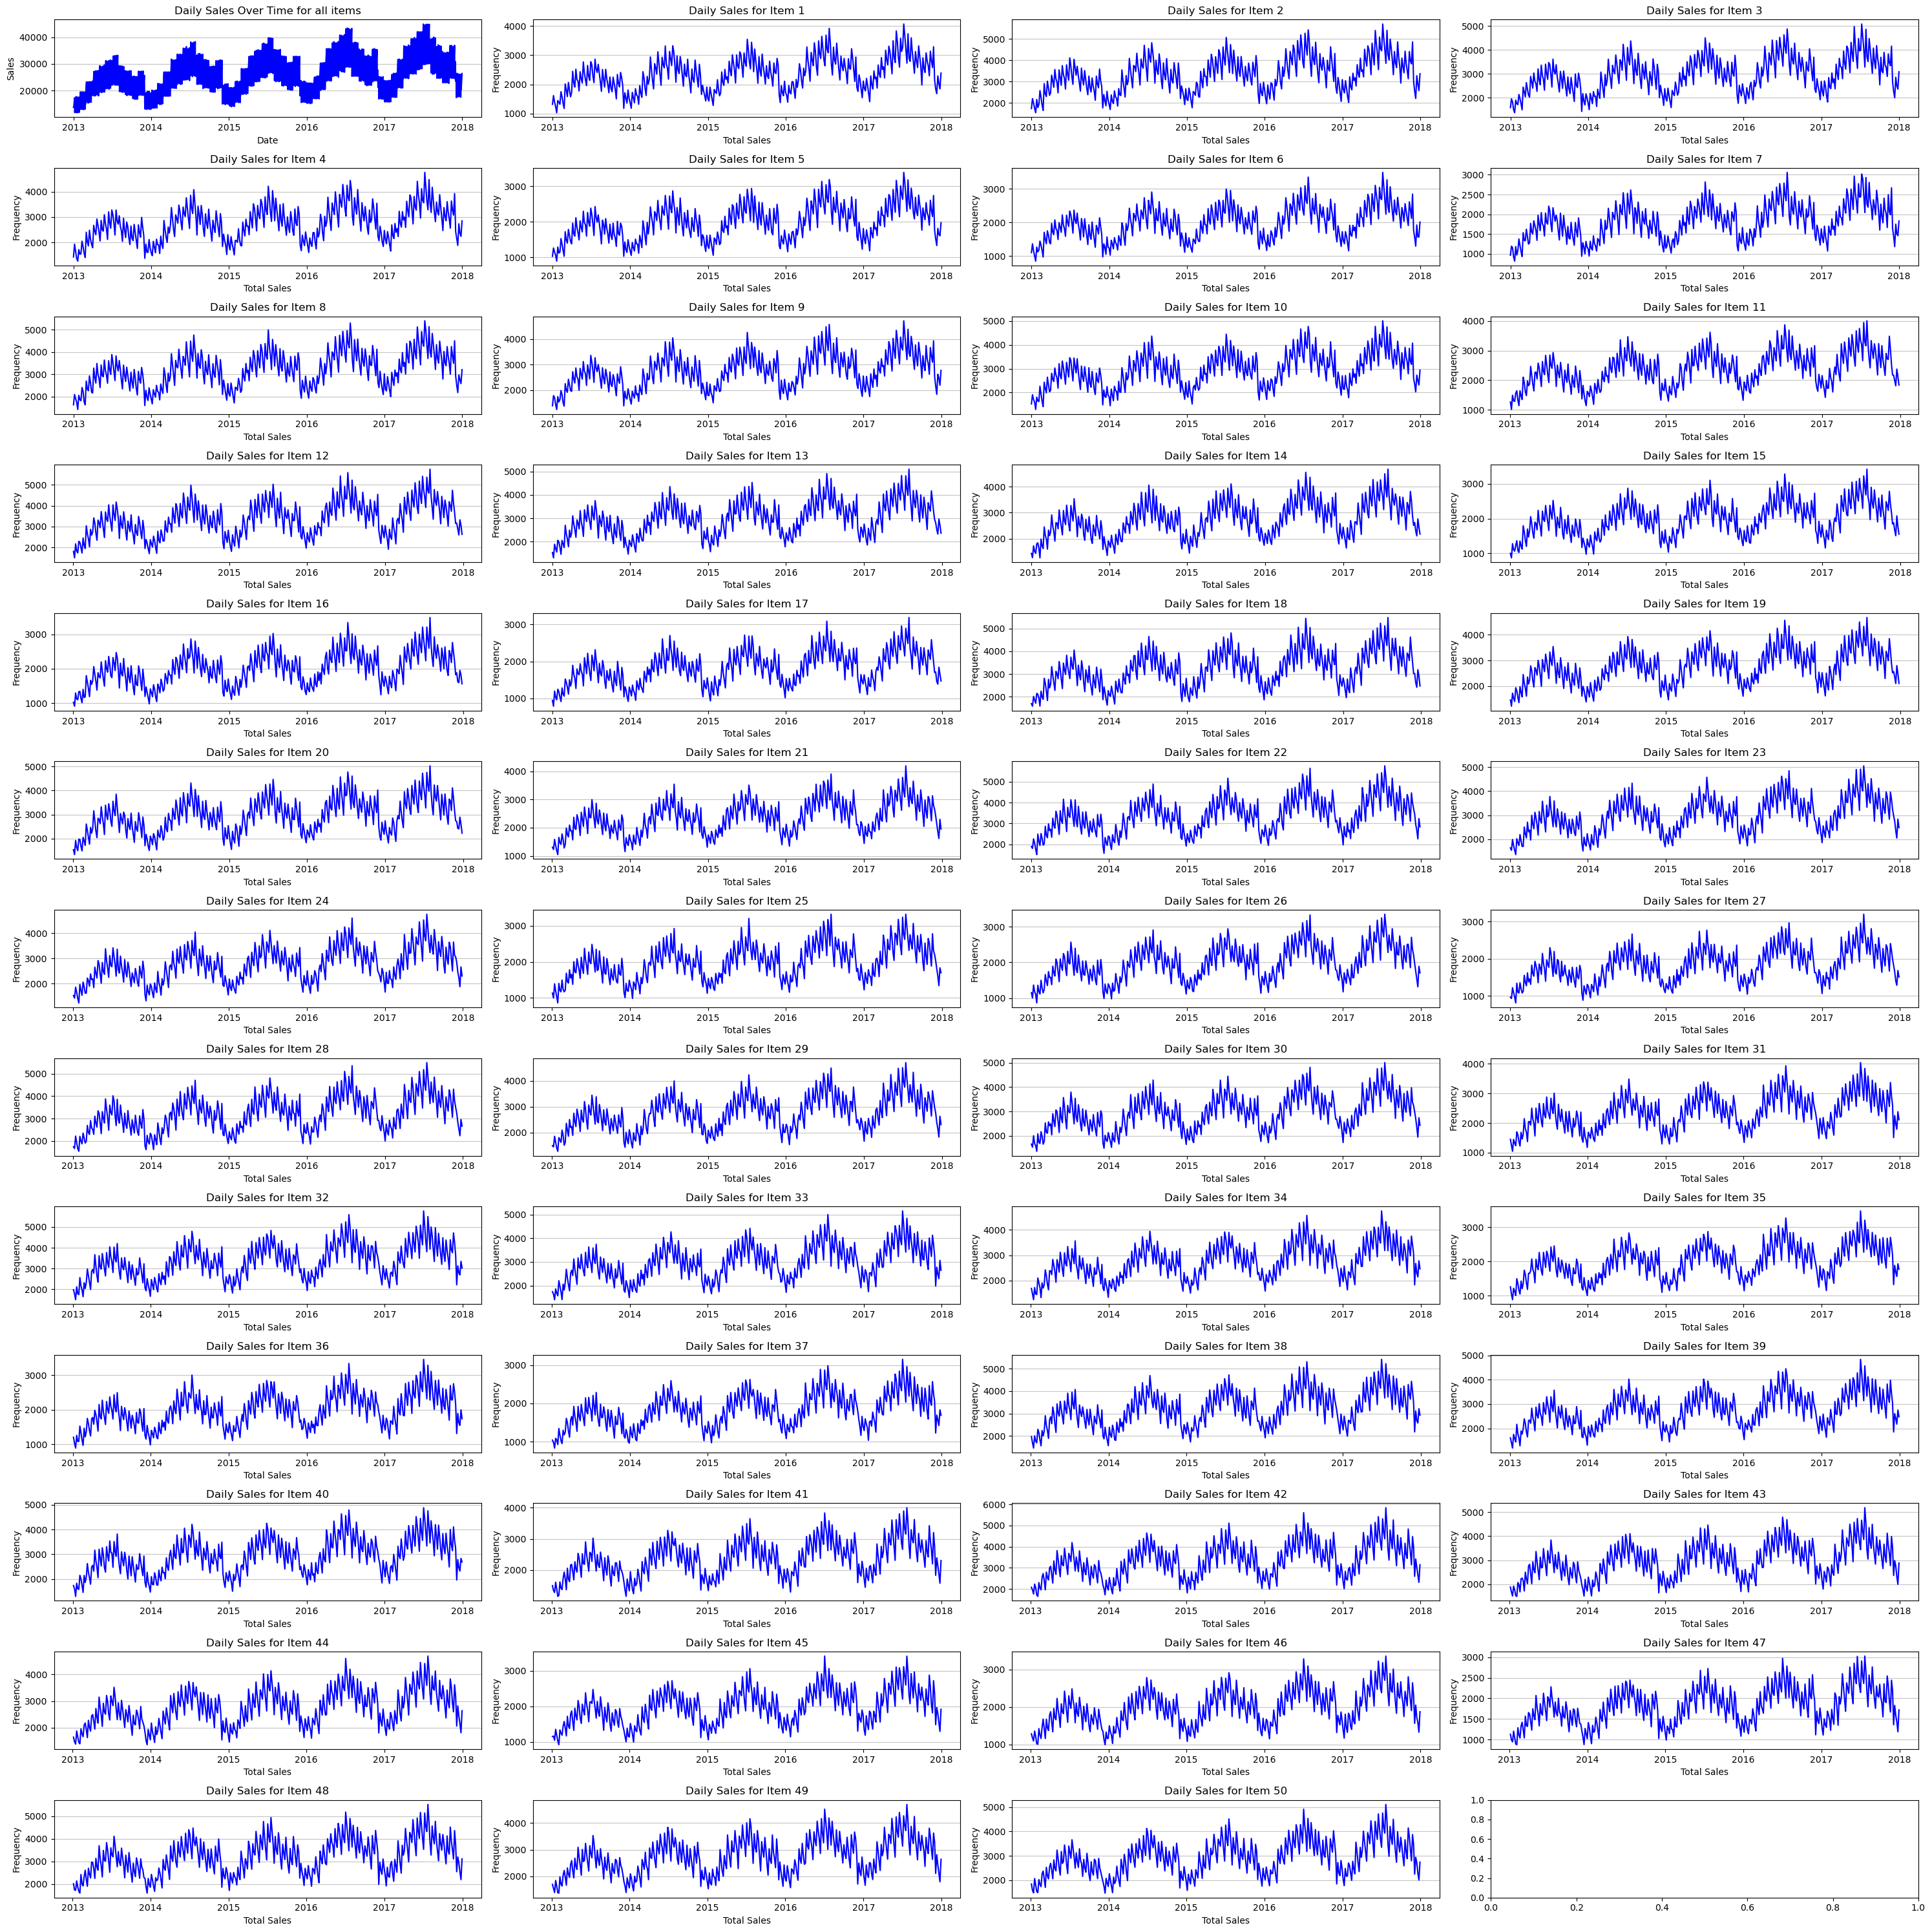

In [16]:
# Calculate daily sales for each item and plot the time series plots

daily_item_sales = df_train.groupby(['date', 'item'])['sales'].sum().reset_index()

fig, ax = plt.subplots(nrows=13, ncols=4, figsize=(30, 30))

ax[0,0].plot(daily_sales['date'], daily_sales['sales'], label='Daily Sales', color='b', linestyle='-')
ax[0,0].set_title('Daily Sales Over Time for all items')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Sales')
ax[0,0].grid(axis='y', alpha=0.75)

for item_number in range(1, 51):  # Range from 1 to 50 (inclusive)
    i, j = divmod(item_number, 4)  # Calculate the row and column indices based on item_number
    
    # Plot starting from the second row and first column
    item_data = daily_store_sales[daily_item_sales['item'] == item_number]['sales']
    item_date = daily_store_sales[daily_item_sales['item'] == item_number]['date']

    ax[i, j].plot(item_date, item_data, label='Daily Sales', color='b', linestyle='-')
    ax[i, j].set_title(f'Daily Sales for Item {item_number}')
    ax[i, j].set_xlabel('Total Sales')
    ax[i, j].set_ylabel('Frequency')
    ax[i, j].grid(axis='y', alpha=0.75)
    
plt.tight_layout()
plt.show()


Again, the plots of each item is very similar. Seems like a synthetic dataset generated with the same parameters for each store and each item plus some noise. Next we will check for any degeneracies in the data. 


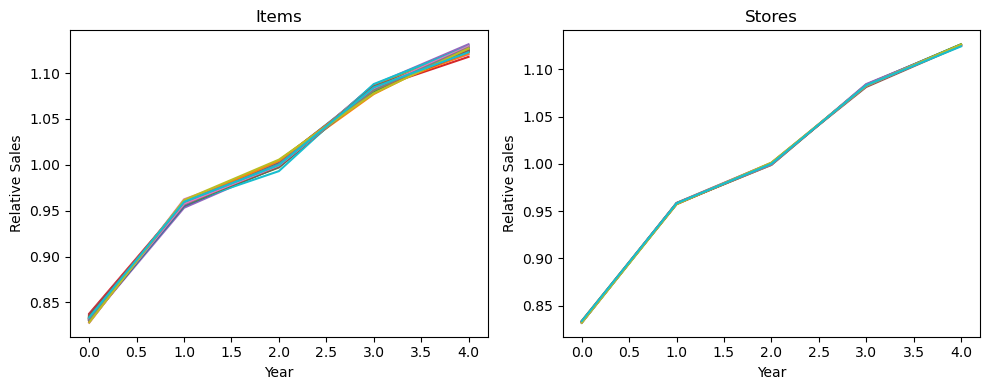

In [17]:
# Calculate mean sales for each combination of 'year' and 'item'
agg_year_item = df_train.groupby(['year', 'item'])['sales'].mean().unstack().values

# Calculate mean sales for each combination of 'year' and 'store'
agg_year_store = df_train.groupby(['year', 'store'])['sales'].mean().unstack().values

# Normalize by the mean sales for each item or store across all years
agg_year_item_relative = agg_year_item / agg_year_item.mean(axis=0)
agg_year_store_relative = agg_year_store / agg_year_store.mean(axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(agg_year_item_relative)
ax[0].set_title("Items")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Relative Sales")

plt.subplot(122)
ax[1].plot(agg_year_store_relative)
ax[1].set_title("Stores")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Relative Sales")

plt.tight_layout()
plt.show()
#print("All items and stores seem to enjoy a similar growth in sales over the years.")

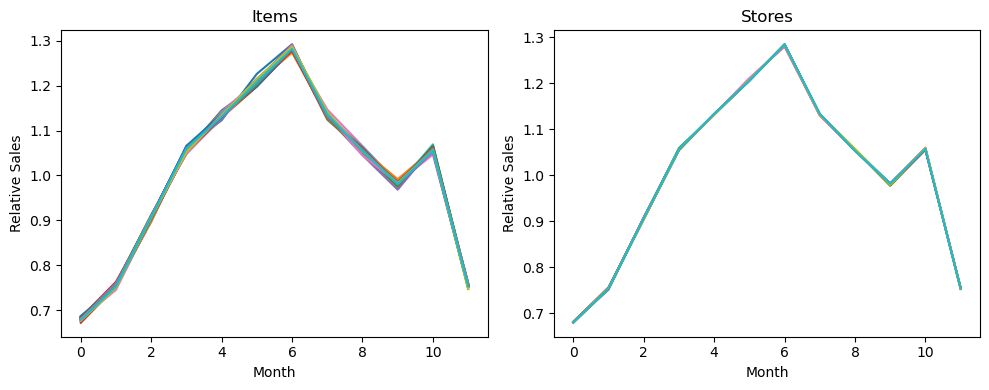

In [18]:
# Calculate mean sales for each combination of 'year' and 'item'
agg_month_item = df_train.groupby(['month', 'item'])['sales'].mean().unstack().values

# Calculate mean sales for each combination of 'year' and 'store'
agg_month_store = df_train.groupby(['month', 'store'])['sales'].mean().unstack().values

# Normalize by the mean sales for each item or store across all years
agg_month_item_relative = agg_month_item / agg_month_item.mean(axis=0)
agg_month_store_relative = agg_month_store / agg_month_store.mean(axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(agg_month_item_relative)
ax[0].set_title("Items")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Relative Sales")

plt.subplot(122)
ax[1].plot(agg_month_store_relative)
ax[1].set_title("Stores")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Relative Sales")

plt.tight_layout()
plt.show()
#print("All items and stores seem to enjoy a similar growth in sales over the years.")

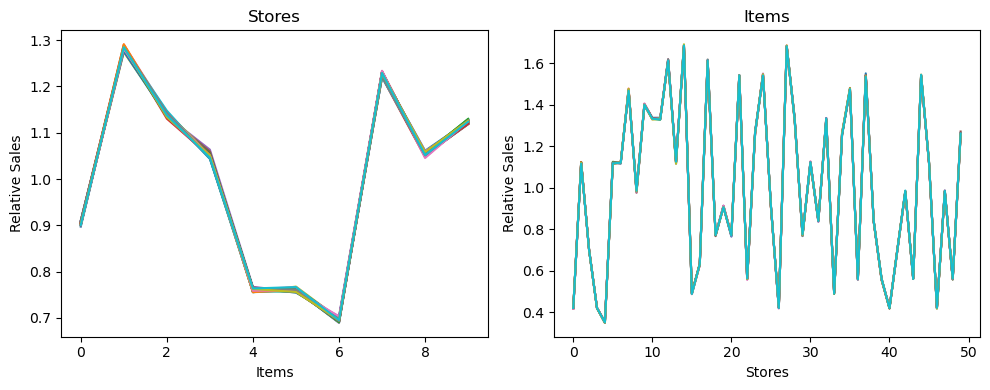

In [19]:
# Calculate mean sales for each combination of 'store' and 'item'
agg_store_item = df_train.groupby(['store', 'item'])['sales'].mean().unstack().values

# Calculate mean sales for each combination of 'year' and 'store'
agg_month_store = df_train.groupby(['month', 'store'])['sales'].mean().unstack().values

# Normalize by the mean sales for each item or store across all years
agg_store_item_relative = agg_store_item / agg_store_item.mean(axis=0)
agg_item_store_relative = agg_store_item.T / agg_store_item.T.mean(axis=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(agg_store_item_relative)
ax[0].set_title("Stores")
ax[0].set_xlabel("Items")
ax[0].set_ylabel("Relative Sales")

plt.subplot(122)
ax[1].plot(agg_item_store_relative)
ax[1].set_title("Items")
ax[1].set_xlabel("Stores")
ax[1].set_ylabel("Relative Sales")

plt.tight_layout()
plt.show()
#print("All items and stores seem to enjoy a similar growth in sales over the years.")

From the plots above we can see that there are no apparant degeneracies in the data and that no relationship exists between store and item over month/year. 

<Figure size 640x480 with 0 Axes>

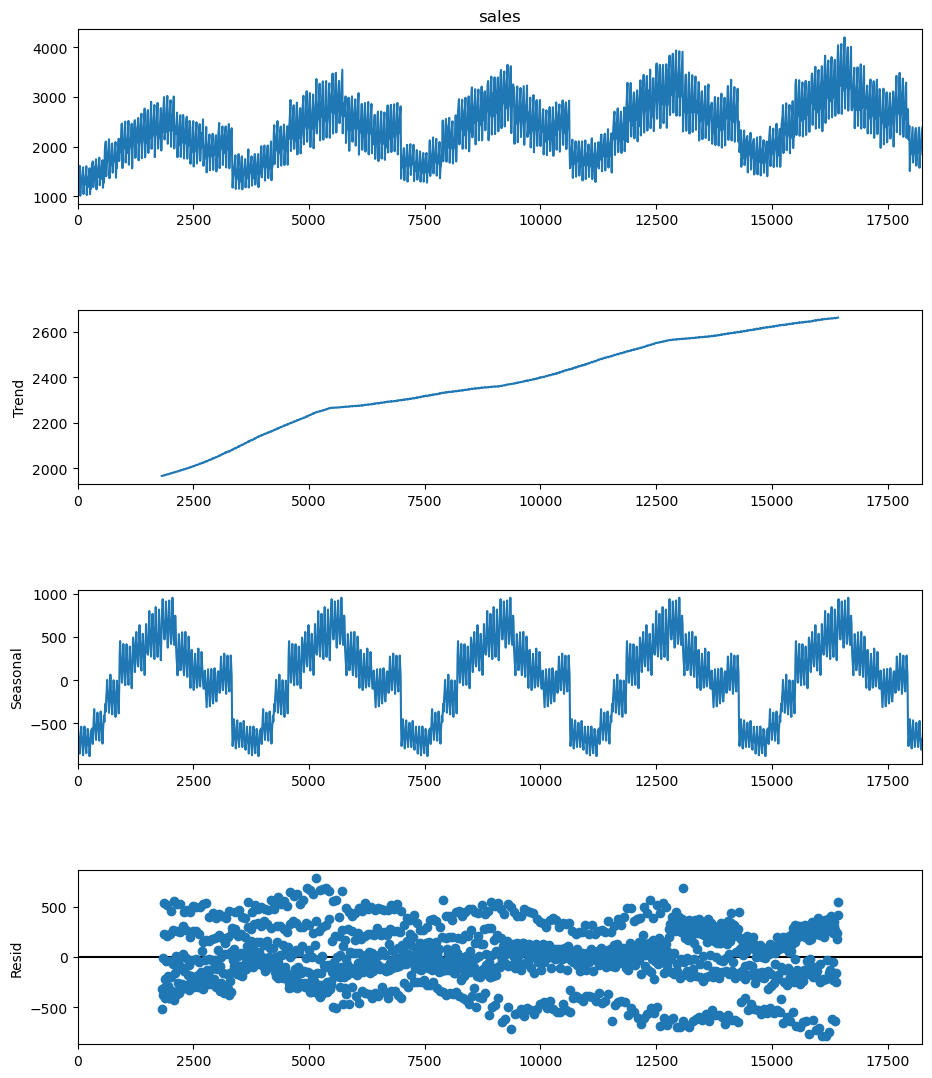

In [20]:
# Decompsing the store 1 daily sales plot into trend, seasonality and resildual assuming an additive model

result = seasonal_decompose(daily_store1_sales['sales'], model='additive', period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 12)

<Figure size 640x480 with 0 Axes>

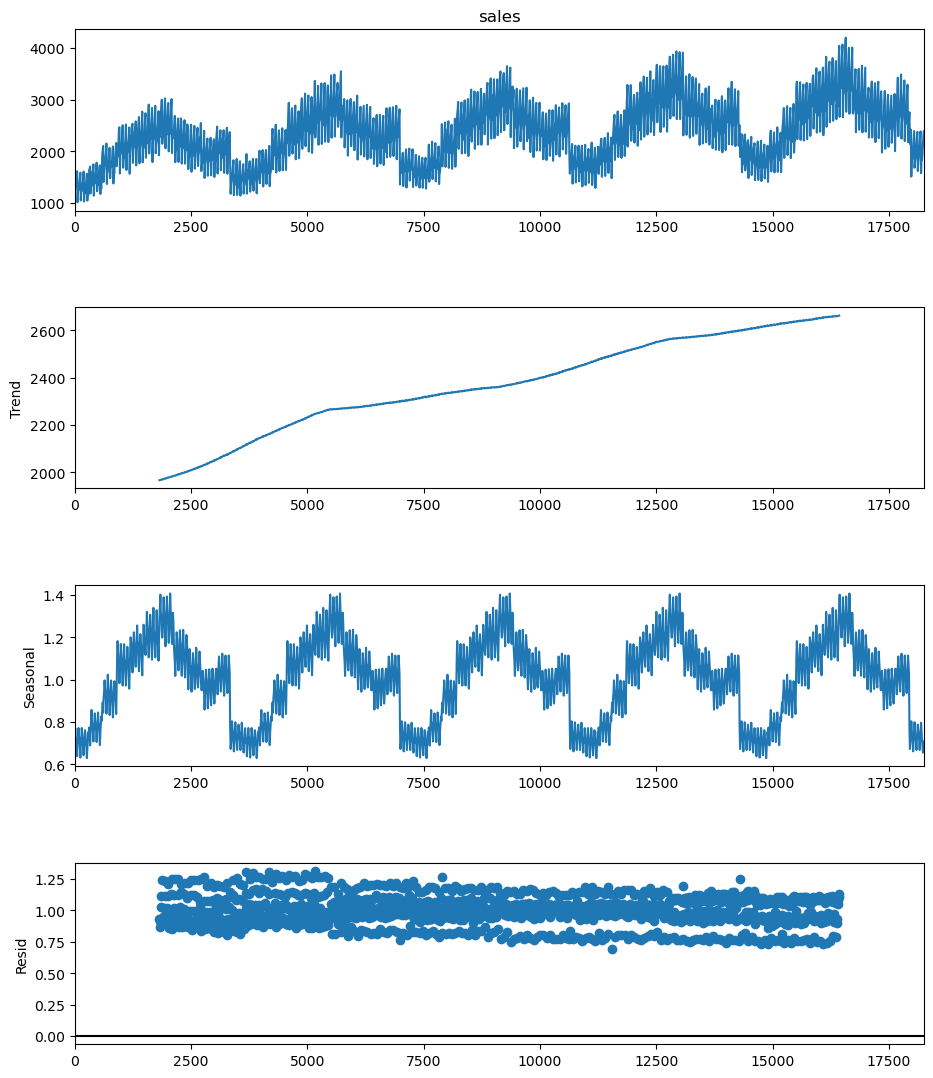

In [21]:
# Decompsing the store 1 daily sales plot into trend, seasonality and resildual assuming an additive model

result = seasonal_decompose(daily_store1_sales['sales'], model='multiplicative', period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 12)

There are 11 'nan' values in the 'TotalCharges' column. The 'tenure' column has 0 value for those entries. So it is not possible to use the 'tenure' * 'MonthlyCharges' to fill in the missing values. 

Will drop these rows and move ahead. 

From the decomposition plots we can see that the additive model gives a better estimate of trend and seasonlity because the residuals are more normally distributed and random. 